In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

In [2]:
file_list = []
for dirpath, _, filenames in os.walk('../data/LiverCT'):
    for filename in filenames:
        file_list.append(os.path.join(dirpath, filename))

In [3]:
def load_nii_as_array(filepath):
    ct_scan = nib.load(filepath).get_fdata()
    array = np.array(ct_scan, dtype=np.float32)
    return np.rot90(array)

def load_sample(sample_num):
    return (load_nii_as_array(f'../data/LiverCT/volume_pt1/volume-{sample_num}.nii'),
        load_nii_as_array(f'../data/LiverCT/segmentations/segmentation-{sample_num}.nii'))

ct, mask = load_sample(0)
print(ct.shape)
print(mask.shape)
print(ct.dtype)

(512, 512, 75)
(512, 512, 75)
float32


In [4]:
ct.min(), ct.max(), mask.min(), mask.max()

(-3024.0, 1410.0, 0.0, 2.0)

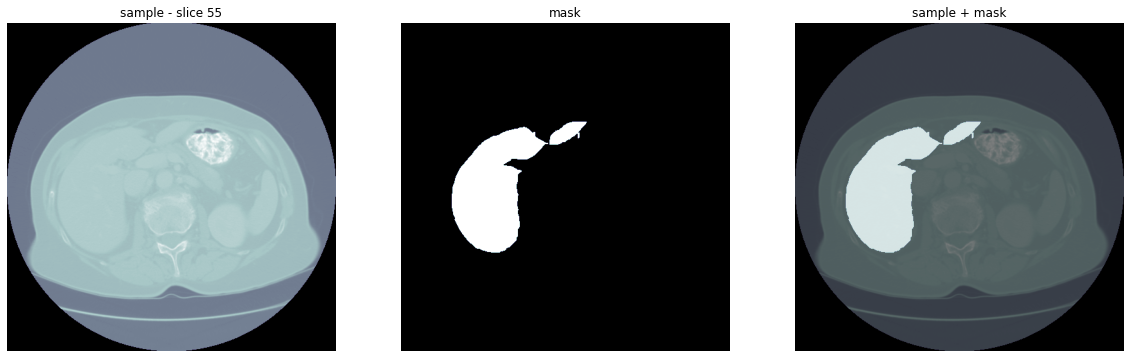

In [5]:
def vis(ct, mask=None, slice=0, cmap=plt.cm.bone):
    if mask is not None:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
    else:
        fig, ax1 = plt.subplots(figsize=(10, 10))

    ax1.imshow(ct[..., slice], cmap=cmap)
    ax1.set_title(f'sample - slice {slice}')
    ax1.axis('off')

    if mask is not None:
        ax2.imshow(mask[..., slice], cmap=cmap)
        ax2.set_title('mask')
        ax2.axis('off')

        ax3.imshow(ct[..., slice], cmap=plt.cm.bone)
        ax3.imshow(mask[..., slice], alpha=0.5, cmap=cmap)
        ax3.set_title('sample + mask')
        ax3.axis('off')

vis(ct, mask, 55)

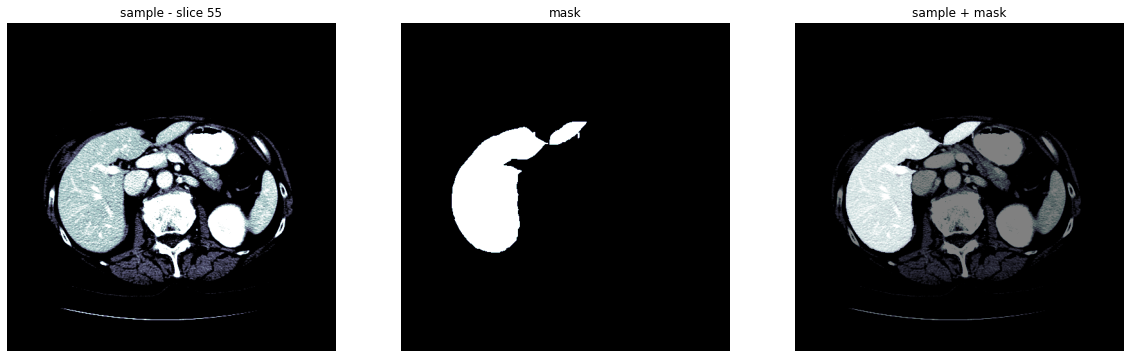

In [6]:
dicom_windows = {
    'brain': (40, 80),
    'subdural': (100, 254),
    'stroke': (8, 32),
    'brain_bone': (600, 2800),
    'brain_soft': (40, 375),
    'lungs': (-600, 1500),
    'mediastinum': (50, 350),
    'abdomen_soft': (50, 400),
    'liver': (30, 150),
    'spine_soft': (50, 250),
    'spine_bone': (400, 1800),
    'custom': (60, 200)
}

def apply_window(ct, window):
    ''' clip and scale '''
    clipped = np.clip(ct, window[0], window[1])
    return (clipped - window[0]) / (window[1] - window[0])

ct_windowed = apply_window(ct, dicom_windows['liver'])
vis(ct_windowed, mask, slice=55)

(256, 256, 75)


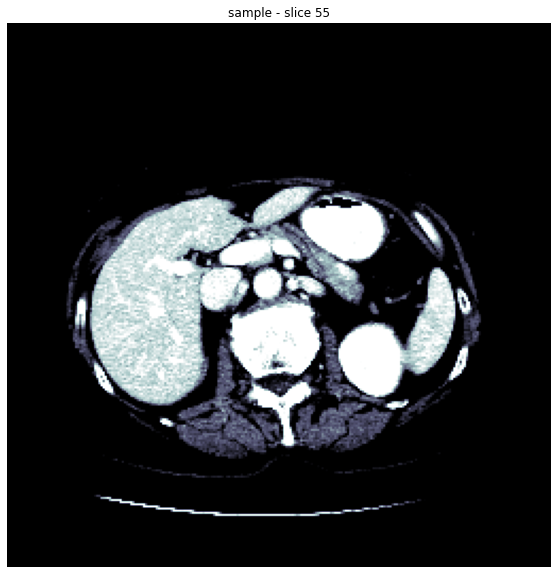

In [7]:
def resample(ct, avg_pooling=False):
    ''' resample (512x512 to 256x256), max pooling by default '''
    bin_size = 512 // 256
    n_slices = ct.shape[2]
    reshaped = ct.reshape((256, bin_size, 256, bin_size, n_slices))
    return reshaped.max(3).max(1) if not avg_pooling else reshaped.mean(3).mean(1)

# max pooling resampling
ct_resampled = resample(ct_windowed)
print(ct_resampled.shape)
vis(ct_resampled, slice=55)

(256, 256, 75)
float32


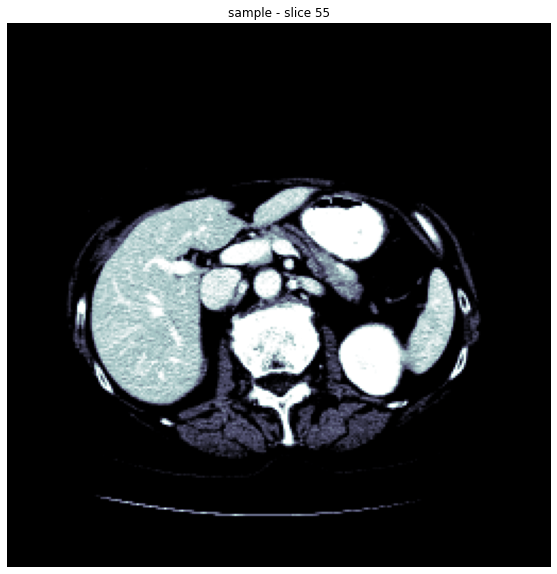

In [9]:
# avg pooling resampling
ct_resampled = resample(ct_windowed, avg_pooling=True)
print(ct_resampled.shape)
vis(ct_resampled, slice=55)
print(ct_resampled.dtype)

uint8


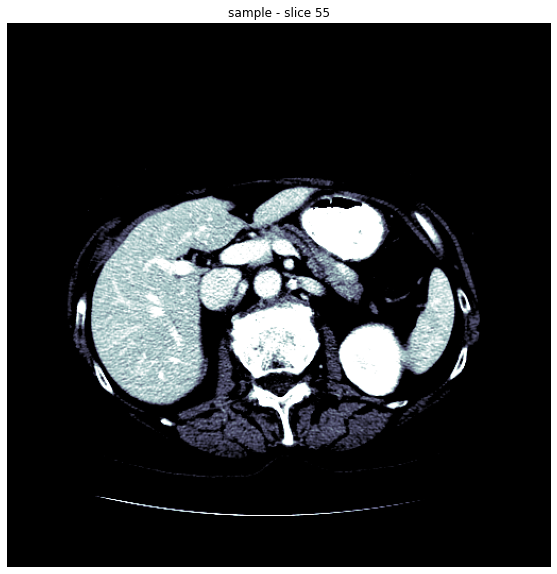

In [10]:
# convert to uint8
ct_win_int = (ct_windowed * 255).astype(np.uint8)
vis(ct_win_int, slice=55)
print(ct_win_int.dtype)